<div>
    <center style='font-size:160%'>Demo Notebook on FinBoost Library</center> 
   
</div> 

---

This notebook walks through the baisc functionality of FinBoost library

<span style='color:#504EFF'>@Fintelligence</span>
<div>
<img src='materials/FI_logo.png' style='width:10%'><img>
</div>


In [1]:
import sys
import os

sys.path.append("..")

> **<span style='color:#504EFF'>FinBoost</span>** Library is a python library for customized gradient boosting tree. The system is available as an open source package

Tree boosting is a highly effective and widely used machine learning method, a de-facto choice of state-of-the-art algorithm for tabular data. 

In [2]:
import FinBoost

print(FinBoost.__version__)

## GBTree
from FinBoost.boosting import GradientBoostingRegressor


0.1.0


In [8]:
# common Scientific package
import pandas as pd
import numpy as np
from scipy.stats import t

import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


In [4]:
# set up the random seed for reproducibility
random.seed(666)
np.random.seed(666)


---

# Simulate Synthetic Data

This module generates the simulated $X$ and $Y$ data for fitting and testing the ML model. 

The true model is assumeted to be:
$$
Y = X_1 + X_2 + X_1 X_2 + \epsilon
$$

Where,

The <span style='color:#504EFF'>*independent variables $X=(X_1, X_2)$*</span> are standard normal distribution with different mean: 
$$
X_1 \sim \mathcal{N}(0, 1) \\
X_2 \sim \mathcal{N}(1, 1)
$$

The <span style='color:#504EFF'>*residual term*</span> follows a heavy-tailed t-distribution with degree of freedom ($df=6$):
$$
 \epsilon \sim \mathcal{T}(df=6)
$$

> t-distribution looks like normal, though with slightly heavier tails.

In [5]:
n_obs = 100000

sim_X1 = np.random.normal(size=n_obs)
sim_X2 = np.random.normal(loc=1, size=n_obs)

sim_residuals = t.rvs(df=6, size=n_obs)

sim_Y = sim_X1+sim_X2 + sim_X1*sim_X2 + sim_residuals

## Visualize the Simulated Data's Distribution

* Noise Component

Text(0.5, 1.0, 'Distribution of Simulated Residual')

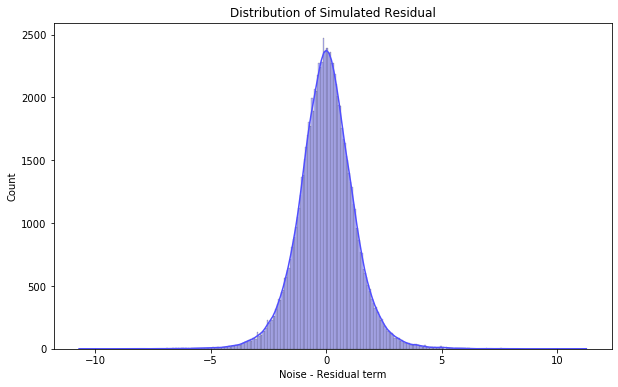

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(sim_residuals,
             ax=ax, color='#504EFF', alpha=0.4,
             kde=True)

ax.set_xlabel('Noise - Residual term')
_ = ax.set_title('Distribution of Simulated Residual')

In [50]:
# mean and standard deviation
print('Mean:{:.2f}; Sd:{:.2f}'.format(np.mean(sim_residuals), np.std(sim_residuals)))

Mean:-0.00; Sd:1.23


* $Y$ versus $X$

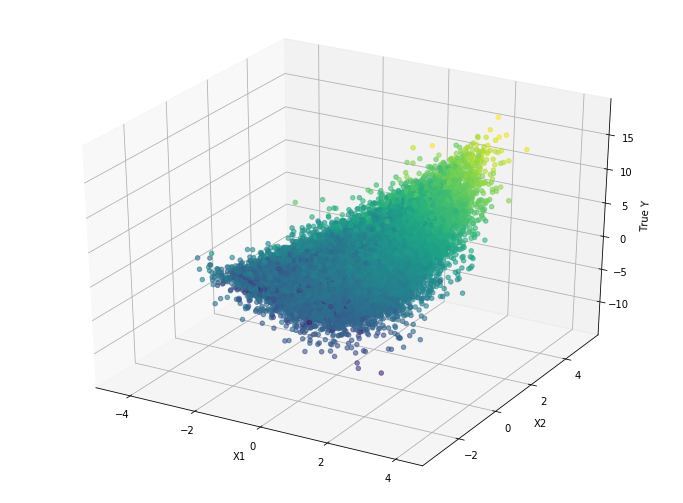

In [52]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(sim_X1, sim_X2, sim_Y, c=sim_Y, alpha=0.6)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('True Y')

plt.show()

## Generate the Experiment Data

* Leave 20% of the total data as test set: $X_{test}, Y_{test}$

* Split the experiment data in advance:
    
    * Training Dataset: _train 
    
    * Test Dataset: _test

In [6]:
X_tot = np.stack([sim_X1, sim_X2], axis=1)
Y_tot = sim_Y

sample_break = int(n_obs*0.8)

## Train Set Data
X_train, Y_train = X_tot[:sample_break], Y_tot[:sample_break]

## Test Set Data
X_test, Y_test = X_tot[sample_break:], Y_tot[sample_break:]


Wrap up the training data as the avilable information for machine learning models to test.

In [7]:
input_data_df = pd.concat([pd.DataFrame(X_train),
                           pd.DataFrame(Y_train)], axis=1)

input_data_df.columns = ['X1', 'X2', 'Y']

input_data_df.head()

X_train, Y_train = input_data_df.loc[:,['X1', 'X2']], input_data_df.loc[:,'Y']


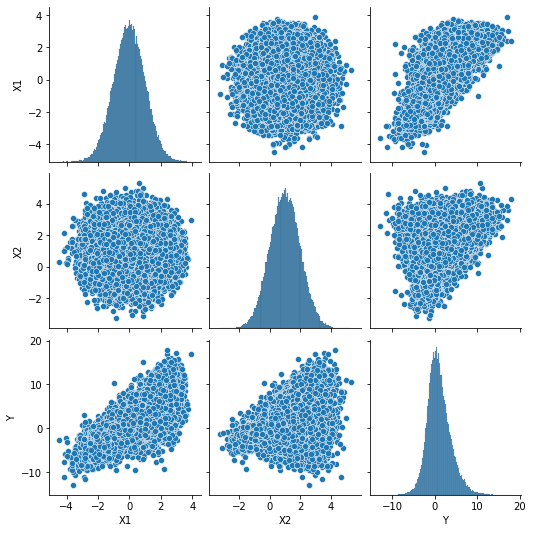

In [73]:
g = sns.pairplot(input_data_df)


---

# Fit a Gridient Boosting Tree



## Model Overview


### GBT Hyperparameter

* learning_rate $\lambda$: 

* n_estimators: The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

* subsample $\eta$:  The fraction of samples to be used for fitting the individual base learners.

In [9]:
# inita a Gradient Boosting Tree
GBT_reg = GradientBoostingRegressor()

In [10]:
GBT_reg

GradientBoostingRegressor()

fit the GBTree model

In [11]:
%%time
GBT_reg.fit(X_train.values, Y_train.values)


CPU times: user 5.03 s, sys: 20.2 ms, total: 5.05 s
Wall time: 5.12 s


GradientBoostingRegressor()

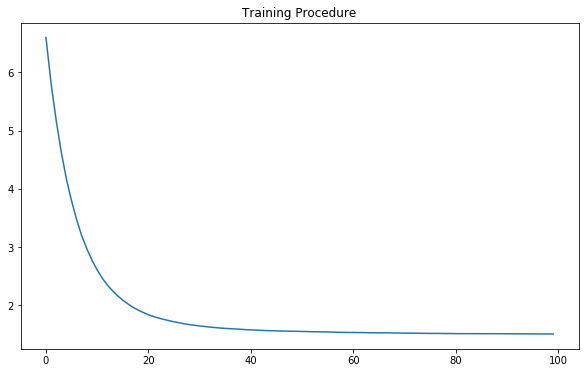

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(GBT_reg.train_score_)
_ = ax.set_title('Training Procedure')

In [13]:
mean_squared_error(GBT_reg.predict(X_test), Y_test)


1.5104382530408043

# Comparison with Other ML Algorithms

In this section, we conduct a model horserace🏇to compare different ML models prediction power using the simulated non-linear dataset.

We use the mean squared error (MSE) to measure the ML models' performance.


## True Model: Upper Bound of Prediction

In [14]:
Y_true_pred_test = X_test[:,0] + X_test[:,1] + X_test[:,0]*X_test[:,1]

mean_squared_error(Y_true_pred_test,
                   Y_test)


1.491388674259212

## Linear Model: ElasticNet

ElasticNet is a linear regression model trained with both $l1$ and $l2-norm$ regularization of the coefficients.
This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. 

apply `ElasticNetCV`


In [14]:
from sklearn.linear_model import ElasticNetCV


In [15]:
eNet_reg_model = ElasticNetCV(cv=5, random_state=0)

eNet_reg_model.fit(X_train, Y_train)

ElasticNetCV(cv=5, random_state=0)

In [17]:
eNet_reg_model.coef_

array([1.99647216, 0.99889199])

In [18]:
mean_squared_error(eNet_reg_model.predict(X_test),
                   Y_test)


2.4785390251034514

## Random Forest


apply `RandomForestRegressor`

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
rf_reg = RandomForestRegressor()


In [24]:
%%time
rf_reg.fit(X_train.values, Y_train.values)


CPU times: user 14.3 s, sys: 283 ms, total: 14.6 s
Wall time: 14.6 s


RandomForestRegressor()

In [25]:
mean_squared_error(rf_reg.predict(X_test), Y_test)



1.7346914045063182

## Other Advanced GBTree

### a. XGBoost

In [19]:
import xgboost as xgb


In [20]:
xgb_reg = xgb.XGBRegressor()


In [ ]:
%%time
xgb_reg.fit(X_train.values, Y_train.values)


In [13]:
mean_squared_error(xgb_reg.predict(X_test), Y_test)


1.5074643078400538

# Conclusion

Gradient boosting tree dominates the performance comparing to other standard machine learning models.